## Deep Learning in Time-series Analysis

In [1]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [3]:
from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

In [4]:
print(tf.__version__)

2.4.1


In [5]:
tf.random.set_seed(42)
np.random.seed(42)

Appliance Energy Dataset

In [6]:
df = pd.read_csv('energydata_complete.csv')
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [7]:
df.shape

(19735, 29)

In [8]:
df = df[::6]
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.890000,47.596667,19.200000,44.79,19.79,44.730000,19.000000,45.566667,17.166667,55.200000,7.026667,84.256667,17.200000,41.626667,18.200000,48.90,17.033333,45.530000,6.6,733.5,92.0,7.0,63.0,5.3,13.275433,13.275433
6,2016-01-11 18:00:00,60,50,19.890000,45.766667,19.200000,44.50,19.79,44.900000,18.890000,45.790000,17.100000,54.966667,6.263333,86.090000,17.133333,41.200000,18.100000,48.59,17.000000,45.290000,5.9,734.1,92.0,5.0,40.0,4.7,47.233763,47.233763
12,2016-01-11 19:00:00,430,50,20.133333,48.000000,19.566667,44.40,19.89,44.900000,19.000000,46.363333,17.100000,55.090000,6.123333,88.590000,17.823333,45.493333,18.066667,48.56,16.963333,45.290000,6.0,734.5,91.0,6.0,40.0,4.6,34.351142,34.351142
18,2016-01-11 20:00:00,80,30,20.890000,51.193333,20.200000,46.33,20.20,48.193333,18.963333,48.630000,17.200000,57.060000,5.333333,86.760000,17.666667,43.160000,18.533333,50.20,16.890000,45.200000,6.0,735.2,88.0,6.0,40.0,4.1,19.001759,19.001759
24,2016-01-11 21:00:00,110,30,21.133333,46.060000,20.426667,44.76,20.29,46.433333,19.390000,48.193333,17.760000,82.460000,5.763333,86.063333,17.856667,43.460000,19.000000,49.76,16.890000,44.966667,6.0,735.4,87.0,6.0,40.0,3.9,13.361033,13.361033


In [9]:
df.shape

(3290, 29)

In [10]:
date_time = pd.to_datetime(df.pop('date'), format='%Y.%m.%d %H:%M:%S')

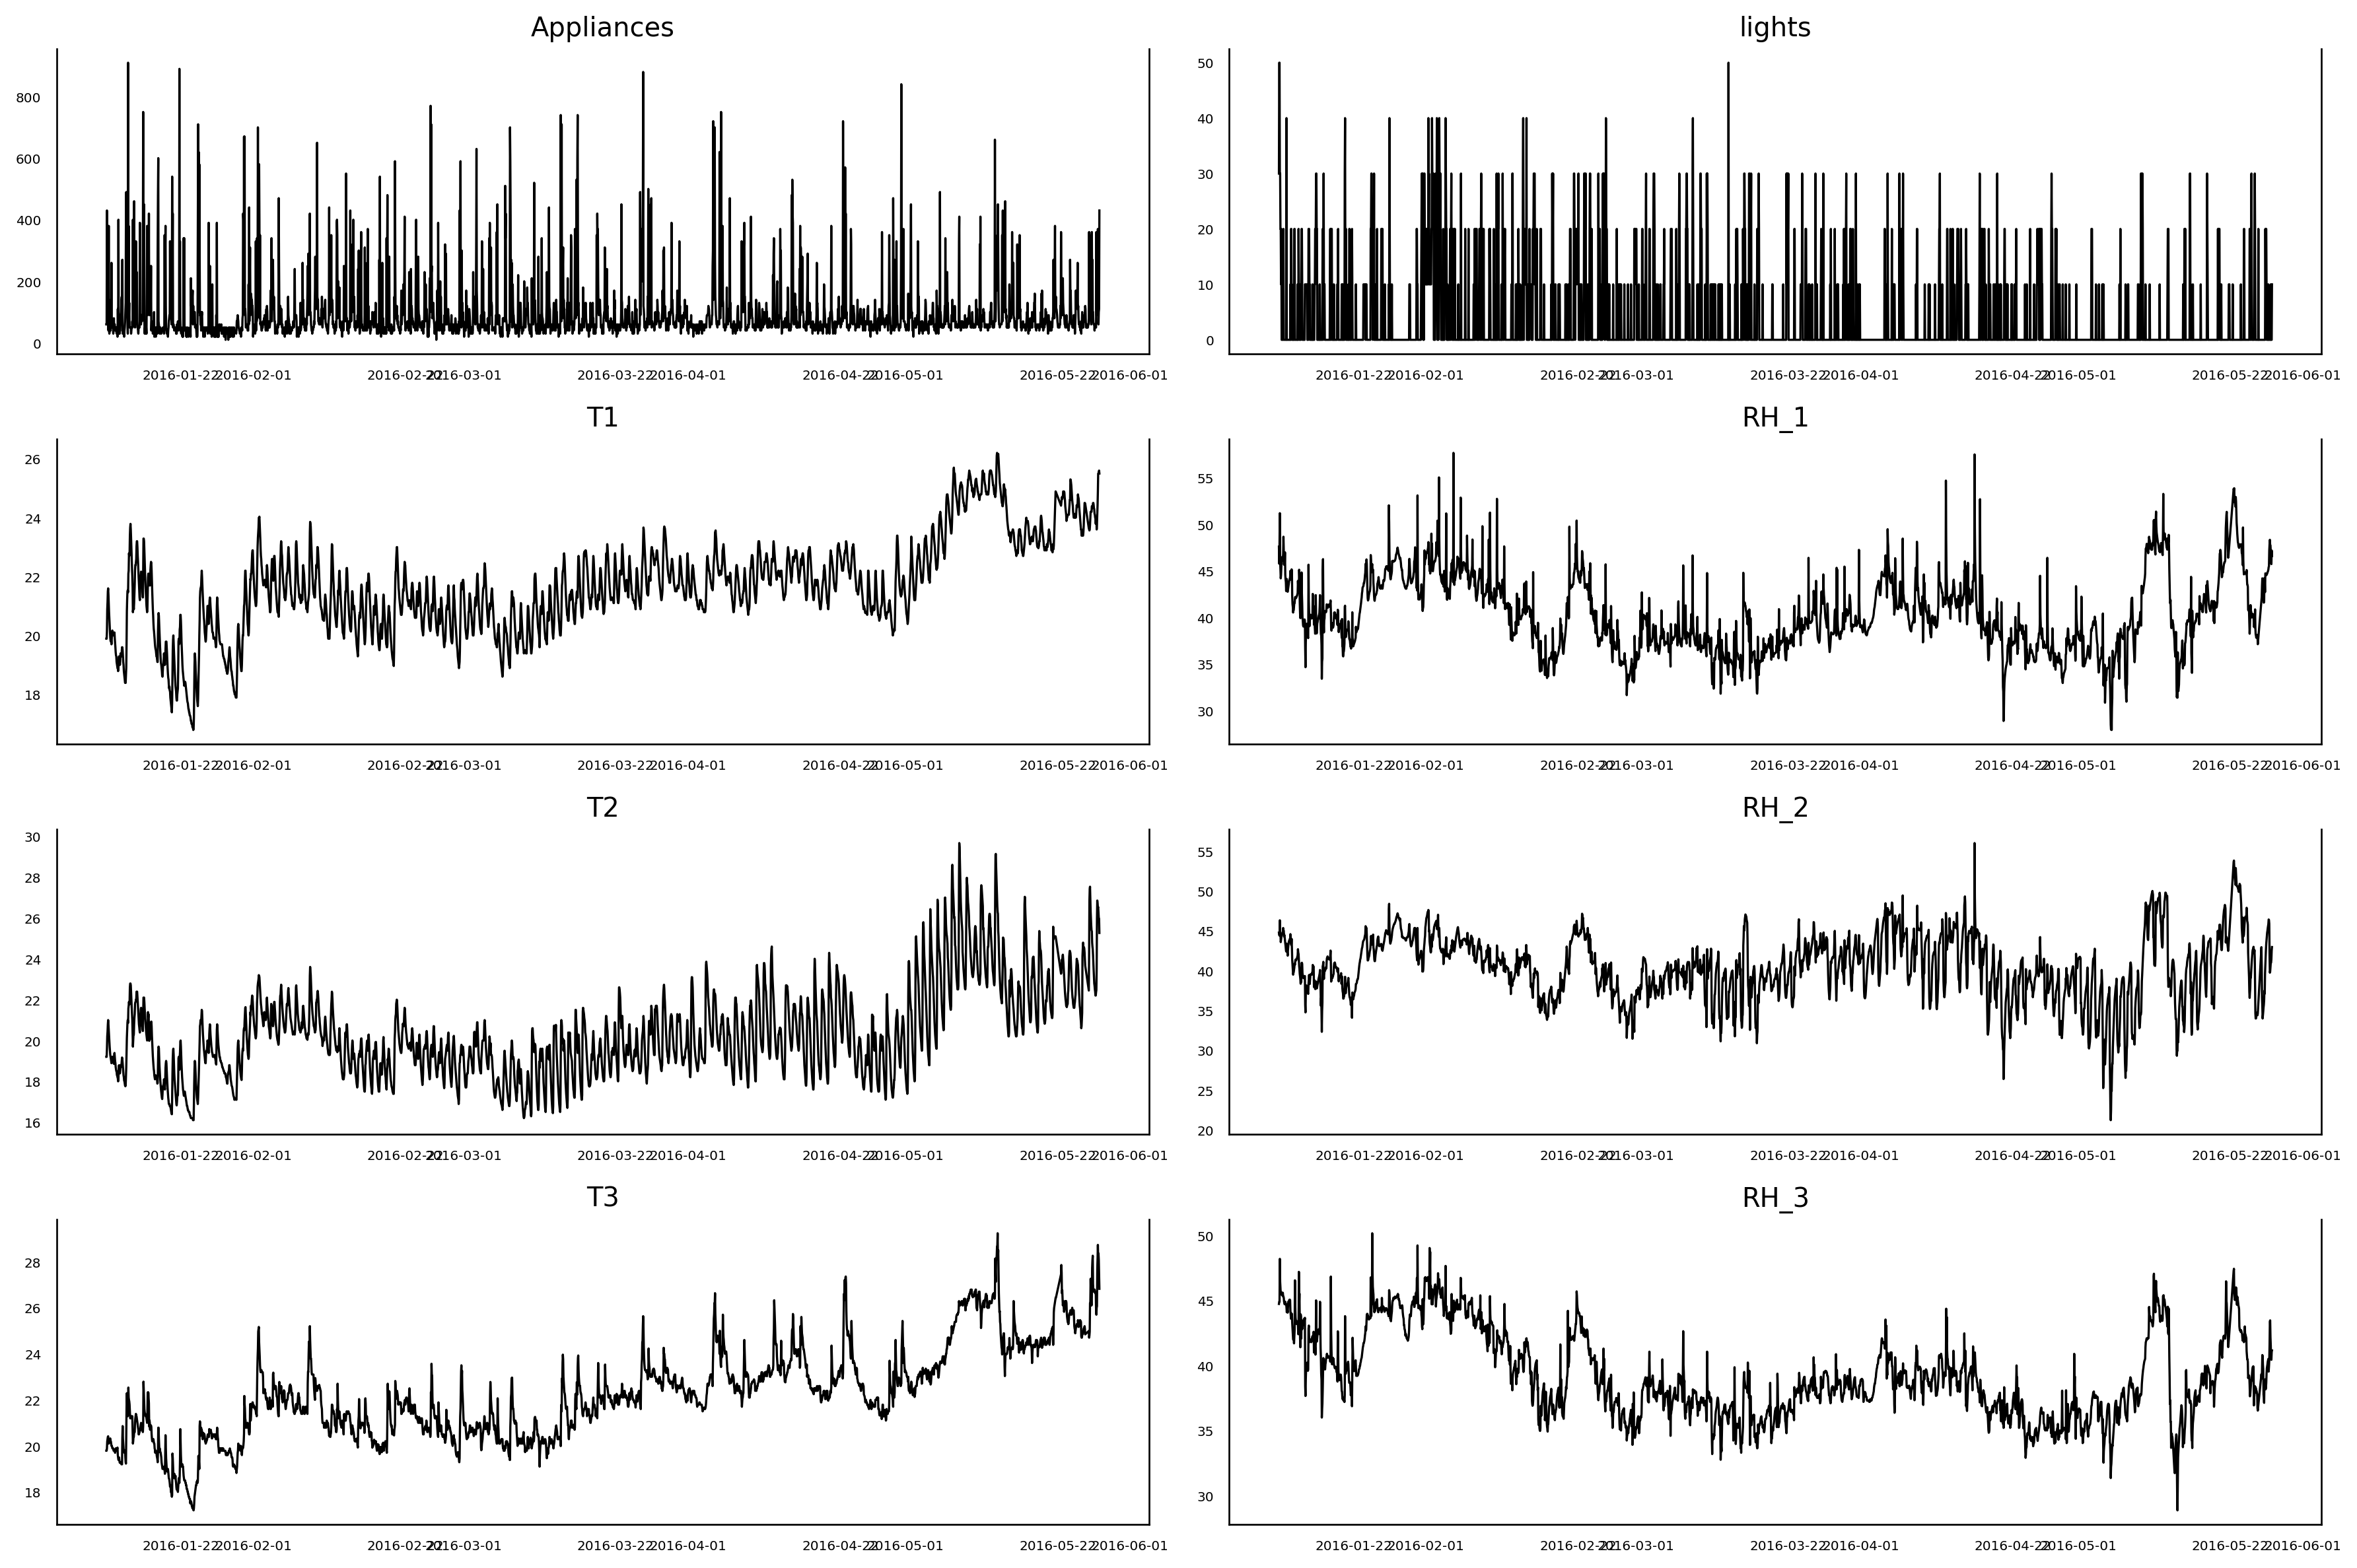

In [11]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=240, figsize=(15, 10))

for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    data.index = date_time
    ax.plot(data, color='black', linewidth=1)

    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

EDA(Exploratory Data Analysis)

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Appliances,3290.0,96.835866,100.459209,10.000000,50.000000,60.000000,100.000000,910.000000
lights,3290.0,3.802432,7.954943,0.000000,0.000000,0.000000,0.000000,50.000000
T1,3290.0,21.686138,1.606259,16.790000,20.737500,21.600000,22.600000,26.200000
RH_1,3290.0,40.262549,3.992042,27.926667,37.372500,39.650833,43.090000,57.663333
T2,3290.0,20.342054,2.195577,16.100000,18.790000,20.000000,21.500000,29.663333
RH_2,3290.0,40.423351,4.072868,21.230000,37.888750,40.500000,43.260000,56.026667
T3,3290.0,22.266861,2.006131,17.200000,20.790000,22.100000,23.290000,29.236000
RH_3,3290.0,39.241405,3.254206,28.860000,36.900000,38.537500,41.752500,50.163333
T4,3290.0,20.856308,2.043188,15.100000,19.500000,20.633333,22.100000,26.140000
RH_4,3290.0,39.026112,4.343764,28.424286,35.527500,38.400000,42.152500,50.963333


- date time year-month-day hour:minute:second
- Appliances, energy use in Wh
- lights, energy use of light fixtures in the house in Wh
- T1, Temperature in kitchen area, in Celsius
- RH1, Humidity in kitchen area, in % T2, Temperature in living room area, in - Celsius RH2, Humidity in living room area, in %
- T3, Temperature in laundry room area
- RH3, Humidity in laundry room area, in % T4, Temperature in office room, in - Celsius RH4, Humidity in office room, in %
- T5, Temperature in bathroom, in Celsius
- RH5, Humidity in bathroom, in % T6, Temperature outside the building (north - side), in Celsius RH6, Humidity outside the building (north side), in %
- T7, Temperature in ironing room , in Celsius
- RH7, Humidity in ironing room, in % T8, Temperature in teenager room 2, in - Celsius RH8, Humidity in teenager room 2, in %
- T9, Temperature in parents room, in Celsius
- RH9, Humidity in parents room, in % To, Temperature outside (from Chievres - weather station), in Celsius Pressure (from Chievres weather station), in mm Hg - RHout, Humidity outside (from Chievres weather station), in %
- Wind speed (from Chievres weather station), in m/s
- Visibility (from Chievres weather station), in km
- Tdewpoint (from Chievres weather station), Â°C
- rv1, Random variable 1, nondimensional
- rv2, Random variable 2, nondimensional

Where indicated, hourly data (then interpolated) from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis, rp5.ru. Permission was obtained from Reliable Prognosis for the distribution of the 4.5 months of weather data.

***
- light : 대부분 값이 0으로 제외  
- rv1,2 : 회귀모형 테스트를 위한 랜덤변수로 제외

In [13]:
drop_cols = ['lights', 'rv1', 'rv2']
df = df.drop(drop_cols, axis=1)

In [14]:
df.shape

(3290, 25)

In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Appliances,3290.0,96.835866,100.459209,10.000000,50.000000,60.000000,100.000000,910.000000
T1,3290.0,21.686138,1.606259,16.790000,20.737500,21.600000,22.600000,26.200000
RH_1,3290.0,40.262549,3.992042,27.926667,37.372500,39.650833,43.090000,57.663333
T2,3290.0,20.342054,2.195577,16.100000,18.790000,20.000000,21.500000,29.663333
RH_2,3290.0,40.423351,4.072868,21.230000,37.888750,40.500000,43.260000,56.026667
T3,3290.0,22.266861,2.006131,17.200000,20.790000,22.100000,23.290000,29.236000
RH_3,3290.0,39.241405,3.254206,28.860000,36.900000,38.537500,41.752500,50.163333
T4,3290.0,20.856308,2.043188,15.100000,19.500000,20.633333,22.100000,26.140000
RH_4,3290.0,39.026112,4.343764,28.424286,35.527500,38.400000,42.152500,50.963333
T5,3290.0,19.593729,1.846567,15.335000,18.290000,19.390000,20.613492,25.466667


Feature Engineering

In [16]:
# Time
timestamp_s = date_time.map(datetime.datetime.timestamp)

Text(0.5, 0, 'Frequency')

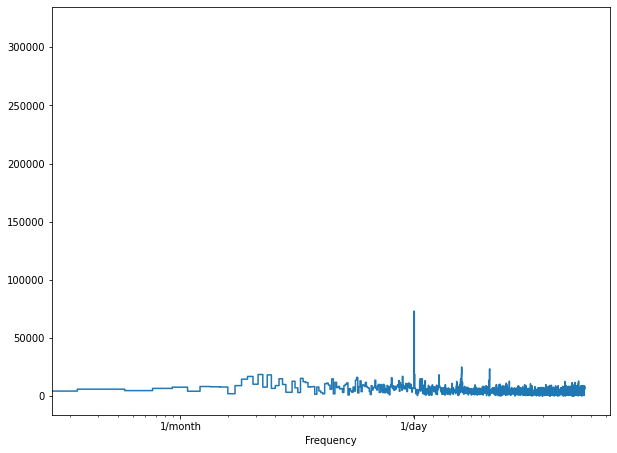

In [17]:
fft = tf.signal.rfft(df['Appliances'])  # Fast Fourier Transform
f_per_dataset = np.arange(0, len(fft))

n_sample_h = len(df['Appliances'])
hours_per_month = 24 * 30.4167  # 월별 평균 일수
months_per_dataset = n_sample_h / hours_per_month

f_per_month = f_per_dataset / months_per_dataset

plt.step(f_per_month, np.abs(fft))
plt.xscale('log')
plt.xticks([1, 30.4167], labels=['1/month', '1/day'])
plt.xlabel('Frequency')

[가정]
- 일단위나 월단위의 계절성이 있을 것이다.

[결과]  
- 월단위의 계절성은 없고 일단위에 계절정은 있는 듯 하다.(특정 피크주파수 확인)

In [20]:
day = 24 * 60 * 60

df['Day sin'] = (np.sin(timestamp_s * (2 * np.pi / day))).values
df['Day cos'] = (np.cos(timestamp_s * (2 * np.pi / day))).values

[참고] Encoding cyclical continuous features - 24-hour time  
https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/

In [21]:
df.head()

,Appliances,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,Day sin,Day cos
0,60,19.890000,47.596667,19.200000,44.79,19.79,44.730000,19.000000,45.566667,17.166667,55.200000,7.026667,84.256667,17.200000,41.626667,18.200000,48.90,17.033333,45.530000,6.6,733.5,92.0,7.0,63.0,5.3,-0.965926,-2.588190e-01
6,60,19.890000,45.766667,19.200000,44.50,19.79,44.900000,18.890000,45.790000,17.100000,54.966667,6.263333,86.090000,17.133333,41.200000,18.100000,48.59,17.000000,45.290000,5.9,734.1,92.0,5.0,40.0,4.7,-1.000000,-9.768282e-12
12,430,20.133333,48.000000,19.566667,44.40,19.89,44.900000,19.000000,46.363333,17.100000,55.090000,6.123333,88.590000,17.823333,45.493333,18.066667,48.56,16.963333,45.290000,6.0,734.5,91.0,6.0,40.0,4.6,-0.965926,2.588190e-01
18,80,20.890000,51.193333,20.200000,46.33,20.20,48.193333,18.963333,48.630000,17.200000,57.060000,5.333333,86.760000,17.666667,43.160000,18.533333,50.20,16.890000,45.200000,6.0,735.2,88.0,6.0,40.0,4.1,-0.866025,5.000000e-01
24,110,21.133333,46.060000,20.426667,44.76,20.29,46.433333,19.390000,48.193333,17.760000,82.460000,5.763333,86.063333,17.856667,43.460000,19.000000,49.76,16.890000,44.966667,6.0,735.4,87.0,6.0,40.0,3.9,-0.707107,7.071068e-01


Split Data

In [23]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
print(n)

# Split 7:2:1
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

print(f'There are {num_features} features')

3290
There are 27 features


Normalize Data

In [24]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

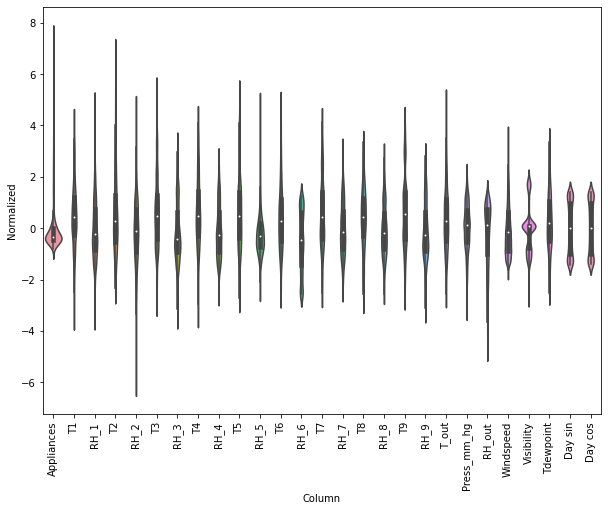

In [25]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')

ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

Data Windowing

In [26]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'
        ])
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='Appliances', max_subplots=3):
        inputs, labels = self.example
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_window)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def example(self):
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.train))
            self._example = result
        return result

In [27]:
MAX_EPOCHS = 50

def compile_and_fit(model, window, patience=3):
    early_stopping = EarlyStopping(monitor='val_loss', 
                                   patience=patience, 
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(), 
                  optimizer=Adam(), 
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=MAX_EPOCHS,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

Single Step Models

In [28]:
single_step_window = WindowGenerator(input_width=1,
                                     label_width=1,
                                     shift=1,
                                     label_columns=['Appliances'])

single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Appliances']

Baseline

In [29]:
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:,:,tf.newaxis]

In [30]:
baseline = Baseline(label_index=column_indices['Appliances'])

baseline.compile(loss=MeanSquaredError(),
                 metrics=[MeanAbsoluteError()])

In [45]:
val_performance = {}
performance = {}

val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

21/21 [==============================] - 0s 3ms/step - loss: 0.7669 - mean_absolute_error: 0.3881


In [46]:
wide_window = WindowGenerator(input_width=24,
                              label_width=24,
                              shift=1,
                              label_columns=['Appliances'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Appliances']

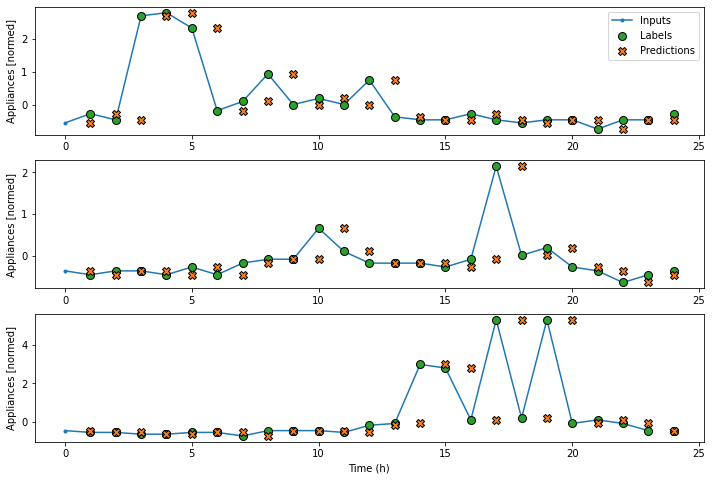

In [47]:
wide_window.plot(baseline)

Linear Model

In [34]:
linear = Sequential([
                     Dense(units=1)
])

In [48]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 1s 7ms/step - loss: 0.8132 - mean_absolute_error: 0.5155 - val_loss: 0.5827 - val_mean_absolute_error: 0.4179
Epoch 2/50
72/72 [==============================] - 0s 5ms/step - loss: 0.7980 - mean_absolute_error: 0.5035 - val_loss: 0.5869 - val_mean_absolute_error: 0.4189
Epoch 3/50
72/72 [==============================] - 0s 6ms/step - loss: 0.7599 - mean_absolute_error: 0.4953 - val_loss: 0.5888 - val_mean_absolute_error: 0.4225
Epoch 4/50
21/21 [==============================] - 0s 4ms/step - loss: 0.5905 - mean_absolute_error: 0.4237


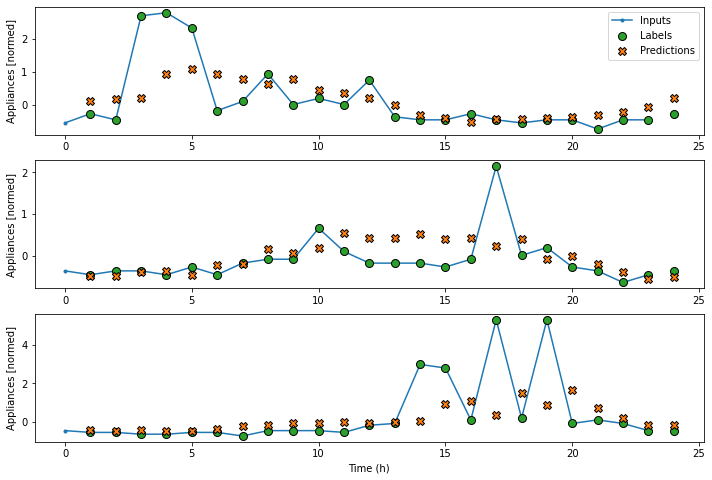

In [49]:
wide_window.plot(linear)

Dense

In [50]:
dense = Sequential([
                    Dense(units=64, activation='relu'),
                    Dense(units=64, activation='relu'),
                    Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 1s 8ms/step - loss: 1.0195 - mean_absolute_error: 0.6180 - val_loss: 0.5504 - val_mean_absolute_error: 0.3753
Epoch 2/50
72/72 [==============================] - 1s 7ms/step - loss: 0.8352 - mean_absolute_error: 0.5146 - val_loss: 0.6333 - val_mean_absolute_error: 0.4352
Epoch 3/50
72/72 [==============================] - 1s 7ms/step - loss: 0.8081 - mean_absolute_error: 0.5090 - val_loss: 0.6498 - val_mean_absolute_error: 0.4513
Epoch 4/50
21/21 [==============================] - 0s 4ms/step - loss: 0.6647 - mean_absolute_error: 0.4568


CNN

In [38]:
CONV_WIDTH = 3

conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Appliances']
)

In [39]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)

wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Appliances']
)

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['Appliances']

In [51]:
cnn_model = Sequential([
                        Conv1D(filters=32, kernel_size=(CONV_WIDTH,), activation='relu'),
                        Dense(units=32, activation='relu'),
                        Dense(units=1)
                        
])

history = compile_and_fit(cnn_model, conv_window)

val_performance['CNN'] = cnn_model.evaluate(conv_window.val)
performance['CNN'] = cnn_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 1s 9ms/step - loss: 0.9468 - mean_absolute_error: 0.6087 - val_loss: 0.7632 - val_mean_absolute_error: 0.5839
Epoch 2/50
72/72 [==============================] - 1s 7ms/step - loss: 0.8317 - mean_absolute_error: 0.5165 - val_loss: 0.7335 - val_mean_absolute_error: 0.5476
Epoch 3/50
72/72 [==============================] - 0s 7ms/step - loss: 0.8252 - mean_absolute_error: 0.5123 - val_loss: 0.7294 - val_mean_absolute_error: 0.5340
Epoch 4/50
72/72 [==============================] - 1s 7ms/step - loss: 0.7785 - mean_absolute_error: 0.4884 - val_loss: 0.6990 - val_mean_absolute_error: 0.5098
Epoch 5/50
72/72 [==============================] - 1s 9ms/step - loss: 0.8096 - mean_absolute_error: 0.4992 - val_loss: 0.7353 - val_mean_absolute_error: 0.5316
Epoch 6/50
72/72 [==============================] - 1s 7ms/step - loss: 0.7499 - mean_absolute_error: 0.4719 - val_loss: 0.7223 - val_mean_absolute_error: 0.5222
Epoch 7/50
21/21 [==========

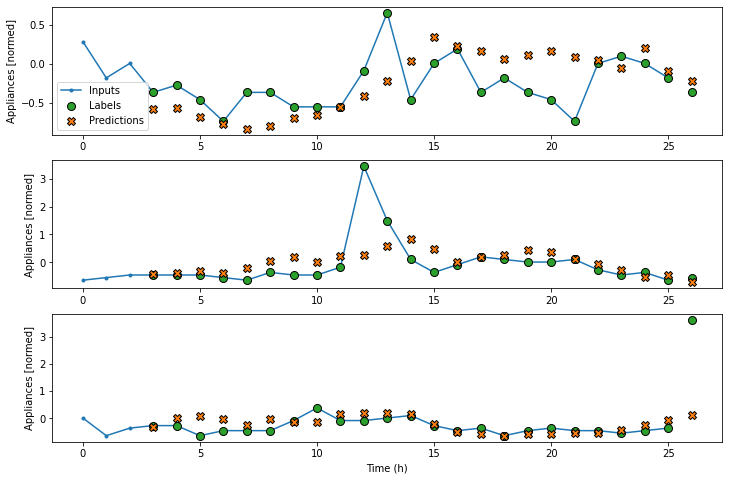

In [52]:
wide_conv_window.plot(cnn_model)

LSTM

In [53]:
lstm_model = Sequential([
                         LSTM(32, return_sequences=True),
                         Dense(units=1)
])

history = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 3s 14ms/step - loss: 1.1106 - mean_absolute_error: 0.6284 - val_loss: 0.5552 - val_mean_absolute_error: 0.3911
Epoch 2/50
72/72 [==============================] - 1s 8ms/step - loss: 0.8404 - mean_absolute_error: 0.5108 - val_loss: 0.5849 - val_mean_absolute_error: 0.4116
Epoch 3/50
72/72 [==============================] - 1s 8ms/step - loss: 0.7603 - mean_absolute_error: 0.4872 - val_loss: 0.5812 - val_mean_absolute_error: 0.4093
Epoch 4/50
20/20 [==============================] - 0s 5ms/step - loss: 0.5792 - mean_absolute_error: 0.4064


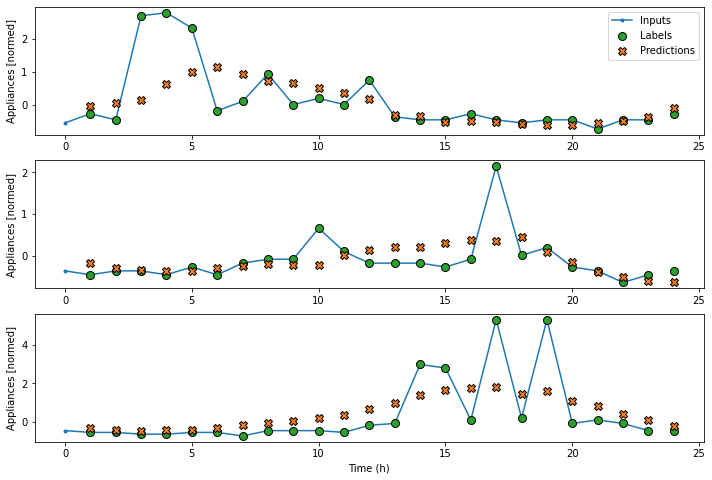

In [54]:
wide_window.plot(lstm_model)

CNN + LSTM

In [55]:
cnn_lstm_model = Sequential([
                             Conv1D(filters=32, kernel_size=(CONV_WIDTH,), activation='relu'),
                             LSTM(32, return_sequences=True),
                             LSTM(32, return_sequences=True),
                             Dense(1)
])

history = compile_and_fit(cnn_lstm_model, conv_window)

val_performance['CNN+LSTM'] = cnn_lstm_model.evaluate(conv_window.val)
performance['CNN+LSTM'] = cnn_lstm_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 4s 17ms/step - loss: 0.9828 - mean_absolute_error: 0.6032 - val_loss: 0.5685 - val_mean_absolute_error: 0.4346
Epoch 2/50
72/72 [==============================] - 1s 9ms/step - loss: 0.8812 - mean_absolute_error: 0.5340 - val_loss: 0.5263 - val_mean_absolute_error: 0.3995
Epoch 3/50
72/72 [==============================] - 1s 8ms/step - loss: 0.8481 - mean_absolute_error: 0.5220 - val_loss: 0.5372 - val_mean_absolute_error: 0.3353
Epoch 4/50
72/72 [==============================] - 1s 8ms/step - loss: 0.7938 - mean_absolute_error: 0.4958 - val_loss: 0.5154 - val_mean_absolute_error: 0.3430
Epoch 5/50
72/72 [==============================] - 1s 8ms/step - loss: 0.7812 - mean_absolute_error: 0.4919 - val_loss: 0.5222 - val_mean_absolute_error: 0.3362
Epoch 6/50
72/72 [==============================] - 1s 8ms/step - loss: 0.7408 - mean_absolute_error: 0.4715 - val_loss: 0.5398 - val_mean_absolute_error: 0.3232
Epoch 7/50
21/21 [=========

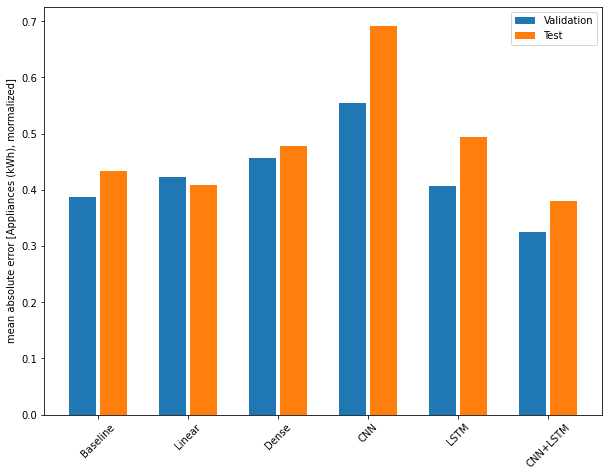

In [56]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')

val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean absolute error [Appliances (kWh), mormalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
plt.legend(loc='best')
plt.show()

In [57]:
for name, value in performance.items():
    print(f'{name}: {value[1]:0.4f}')

Baseline: 0.4342
Linear: 0.4084
Dense: 0.4780
CNN: 0.6909
LSTM: 0.4948
CNN+LSTM: 0.3796


Multi-Output Models

In [58]:
single_step_window = WindowGenerator(
    input_width=1,
    label_width=1,
    shift=1
)

wide_window = WindowGenerator(
    input_width=24,
    label_width=24,
    shift=1
)

CONV_WIDTH = 3

conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1
)

for example_inputs, example_labels in wide_window.train.take(1):
    print(f'Inputs shape (batch, time, features) : {example_inputs.shape}')
    print(f'Labels shape (batch, time, features) : {example_labels.shape}')

Inputs shape (batch, time, features) : (32, 24, 27)
Labels shape (batch, time, features) : (32, 24, 27)


Baseline

In [59]:
baseline = Baseline()
baseline.compile(loss=MeanSquaredError(),
                 metrics=[MeanAbsoluteError()])

val_performance = {}
performance = {}

val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

20/20 [==============================] - 0s 3ms/step - loss: 0.1292 - mean_absolute_error: 0.1780


Dense

In [61]:
dense = Sequential([
                    Dense(64, activation='relu'),
                    Dense(64, activation='relu'),
                    Dense(num_features)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 1s 10ms/step - loss: 0.8665 - mean_absolute_error: 0.7286 - val_loss: 0.5191 - val_mean_absolute_error: 0.5488
Epoch 2/50
72/72 [==============================] - 0s 6ms/step - loss: 0.3144 - mean_absolute_error: 0.4076 - val_loss: 0.3897 - val_mean_absolute_error: 0.4646
Epoch 3/50
72/72 [==============================] - 1s 8ms/step - loss: 0.2277 - mean_absolute_error: 0.3322 - val_loss: 0.3247 - val_mean_absolute_error: 0.4163
Epoch 4/50
72/72 [==============================] - 0s 6ms/step - loss: 0.1833 - mean_absolute_error: 0.2895 - val_loss: 0.2890 - val_mean_absolute_error: 0.3887
Epoch 5/50
72/72 [==============================] - 0s 6ms/step - loss: 0.1626 - mean_absolute_error: 0.2641 - val_loss: 0.2624 - val_mean_absolute_error: 0.3639
Epoch 6/50
72/72 [==============================] - 0s 6ms/step - loss: 0.1515 - mean_absolute_error: 0.2500 - val_loss: 0.2474 - val_mean_absolute_error: 0.3524
Epoch 7/50
72/72 [=========

LSTM

In [62]:
lstm_model = Sequential([
                         LSTM(32, return_sequences=True),
                         Dense(num_features)
])

history = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = dense.evaluate(wide_window.val)
performance['LSTM'] = dense.evaluate(wide_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 3s 17ms/step - loss: 0.9334 - mean_absolute_error: 0.7657 - val_loss: 1.2897 - val_mean_absolute_error: 0.8403
Epoch 2/50
72/72 [==============================] - 1s 9ms/step - loss: 0.4566 - mean_absolute_error: 0.5142 - val_loss: 0.9743 - val_mean_absolute_error: 0.7110
Epoch 3/50
72/72 [==============================] - 1s 9ms/step - loss: 0.3291 - mean_absolute_error: 0.4243 - val_loss: 0.7695 - val_mean_absolute_error: 0.6234
Epoch 4/50
72/72 [==============================] - 1s 9ms/step - loss: 0.2584 - mean_absolute_error: 0.3626 - val_loss: 0.6389 - val_mean_absolute_error: 0.5622
Epoch 5/50
72/72 [==============================] - 1s 8ms/step - loss: 0.2187 - mean_absolute_error: 0.3228 - val_loss: 0.5545 - val_mean_absolute_error: 0.5187
Epoch 6/50
72/72 [==============================] - 1s 9ms/step - loss: 0.1903 - mean_absolute_error: 0.2932 - val_loss: 0.4943 - val_mean_absolute_error: 0.4837
Epoch 7/50
72/72 [=========

CNN+LSTM

In [63]:
cnn_lstm_model = Sequential([
                             Conv1D(32, kernel_size=(CONV_WIDTH,), activation='relu'),
                             LSTM(32, return_sequences=True),
                             LSTM(32, return_sequences=True),
                             Dense(num_features)
])

history = compile_and_fit(cnn_lstm_model, conv_window)

val_performance['CNN+LSTM'] = cnn_lstm_model.evaluate(conv_window.val)
performance['CNN+LSTM'] = cnn_lstm_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 5s 19ms/step - loss: 0.9374 - mean_absolute_error: 0.7777 - val_loss: 1.4810 - val_mean_absolute_error: 0.9289
Epoch 2/50
72/72 [==============================] - 1s 9ms/step - loss: 0.5470 - mean_absolute_error: 0.5657 - val_loss: 0.9195 - val_mean_absolute_error: 0.7005
Epoch 3/50
72/72 [==============================] - 1s 8ms/step - loss: 0.3616 - mean_absolute_error: 0.4402 - val_loss: 0.7508 - val_mean_absolute_error: 0.6225
Epoch 4/50
72/72 [==============================] - 1s 8ms/step - loss: 0.3034 - mean_absolute_error: 0.3933 - val_loss: 0.6800 - val_mean_absolute_error: 0.5900
Epoch 5/50
72/72 [==============================] - 1s 8ms/step - loss: 0.2627 - mean_absolute_error: 0.3606 - val_loss: 0.6393 - val_mean_absolute_error: 0.5664
Epoch 6/50
72/72 [==============================] - 1s 8ms/step - loss: 0.2399 - mean_absolute_error: 0.3375 - val_loss: 0.5885 - val_mean_absolute_error: 0.5423
Epoch 7/50
72/72 [=========

ResNet

In [66]:
class ResidualWrapper(Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

        return inputs + delta

In [67]:
res_lstm = ResidualWrapper(
    Sequential([
                LSTM(32, return_sequences=True),
                Dense(
                    num_features,
                    kernel_initializer=tf.initializers.zeros  # Initailize preds to 0
                )
    ])
)

history = compile_and_fit(res_lstm, wide_window)

val_performance['Res_LSTM'] = res_lstm.evaluate(wide_window.val)
performance['Res_LSTM'] = res_lstm.evaluate(wide_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 2s 13ms/step - loss: 0.1495 - mean_absolute_error: 0.1722 - val_loss: 0.1127 - val_mean_absolute_error: 0.1599
Epoch 2/50
72/72 [==============================] - 1s 7ms/step - loss: 0.1291 - mean_absolute_error: 0.1563 - val_loss: 0.1029 - val_mean_absolute_error: 0.1584
Epoch 3/50
72/72 [==============================] - 1s 8ms/step - loss: 0.1123 - mean_absolute_error: 0.1538 - val_loss: 0.1001 - val_mean_absolute_error: 0.1613
Epoch 4/50
72/72 [==============================] - 1s 9ms/step - loss: 0.1025 - mean_absolute_error: 0.1520 - val_loss: 0.1012 - val_mean_absolute_error: 0.1629
Epoch 5/50
72/72 [==============================] - 1s 9ms/step - loss: 0.0977 - mean_absolute_error: 0.1507 - val_loss: 0.1014 - val_mean_absolute_error: 0.1634
Epoch 6/50
20/20 [==============================] - 0s 5ms/step - loss: 0.1022 - mean_absolute_error: 0.1633


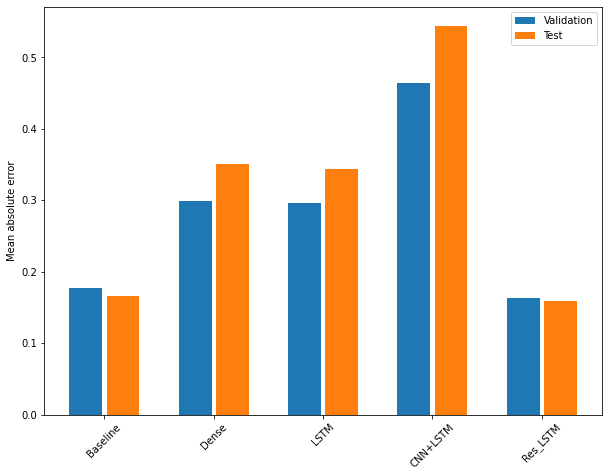

In [68]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')

val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('Mean absolute error')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
plt.legend(loc='best')
plt.show()

In [69]:
for name, value in performance.items():
    print(f'{name:12s} {value[1]:0.4f}')

Baseline     0.1658
Dense        0.3502
LSTM         0.3435
CNN+LSTM     0.5433
Res_LSTM     0.1587


Multi-Step Models

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

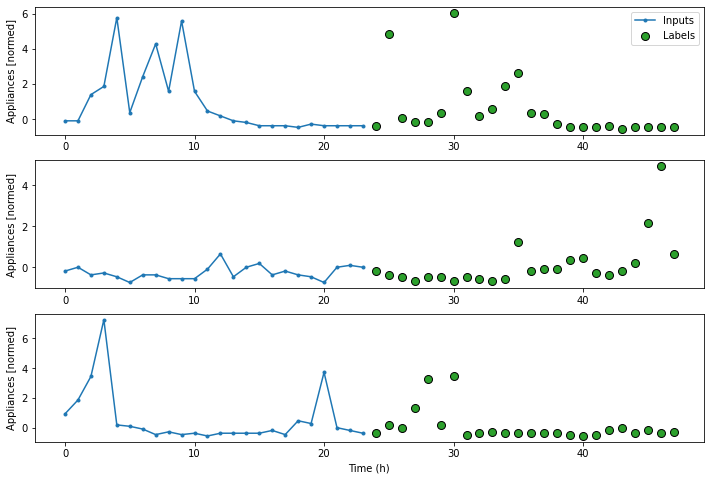

In [70]:
OUT_STEPS = 24

multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)
multi_window.plot()
multi_window

Baseline

In [71]:
class MultiStepLastBaseline(Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

In [73]:
last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=MeanSquaredError(),
                      metrics=[MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)

20/20 [==============================] - 0s 4ms/step - loss: 0.9608 - mean_absolute_error: 0.6570


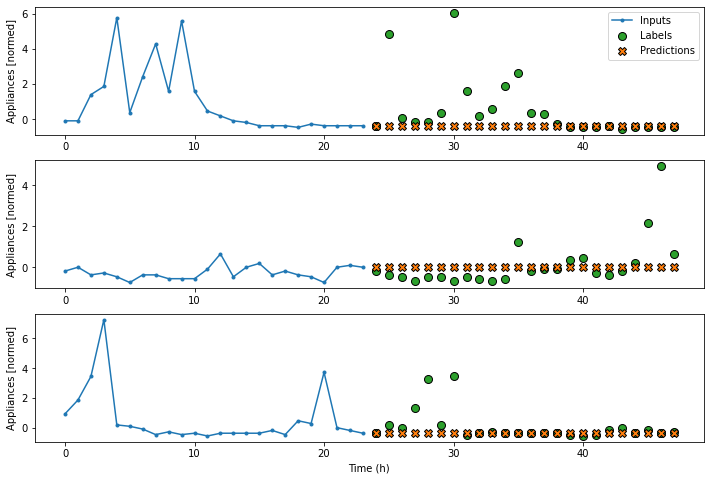

In [74]:
multi_window.plot(last_baseline)

In [75]:
class RepeatBaseline(Model):
    def call(self, inputs):
        return inputs

In [76]:
repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=MeanSquaredError(),
                      metrics=[MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)

20/20 [==============================] - 0s 3ms/step - loss: 0.5314 - mean_absolute_error: 0.4883


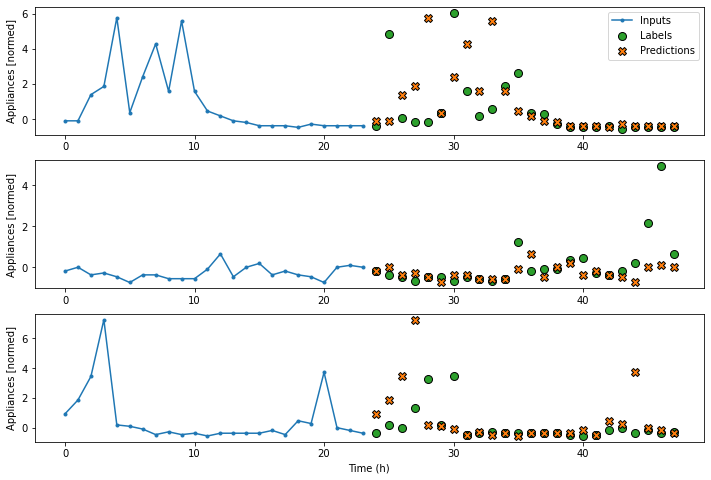

In [77]:
multi_window.plot(repeat_baseline)

Linear - Single shot

In [78]:
multi_linear_model = Sequential([
                                 # Take last time step
                                 Lambda(lambda x: x[:, -1:, :]),  # Shape[batch, time, features] => [batch, 1, features]
                                 Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros),  # Shape[batch, 1, out_steps*features]
                                 Reshape([OUT_STEPS, num_features])  # Shape[batch, out_steps, features]
])

history = compile_and_fit(multi_linear_model, multi_window)

multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
71/71 [==============================] - 1s 8ms/step - loss: 0.8269 - mean_absolute_error: 0.7245 - val_loss: 0.9601 - val_mean_absolute_error: 0.7323
Epoch 2/50
71/71 [==============================] - 0s 6ms/step - loss: 0.4932 - mean_absolute_error: 0.5356 - val_loss: 0.7316 - val_mean_absolute_error: 0.6139
Epoch 3/50
71/71 [==============================] - 0s 6ms/step - loss: 0.4185 - mean_absolute_error: 0.4813 - val_loss: 0.6650 - val_mean_absolute_error: 0.5765
Epoch 4/50
71/71 [==============================] - 0s 6ms/step - loss: 0.3865 - mean_absolute_error: 0.4568 - val_loss: 0.6332 - val_mean_absolute_error: 0.5588
Epoch 5/50
71/71 [==============================] - 0s 5ms/step - loss: 0.3668 - mean_absolute_error: 0.4412 - val_loss: 0.6095 - val_mean_absolute_error: 0.5454
Epoch 6/50
71/71 [==============================] - 0s 6ms/step - loss: 0.3521 - mean_absolute_error: 0.4291 - val_loss: 0.5954 - val_mean_absolute_error: 0.5363
Epoch 7/50
71/71 [==========

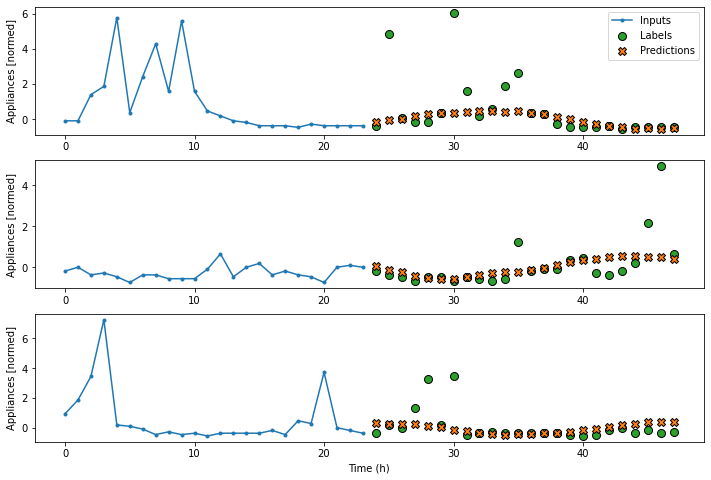

In [79]:
multi_window.plot(multi_linear_model)

Dense - Single shot

In [80]:
multi_dense_model = Sequential([
                                 Lambda(lambda x: x[:, -1:, :]),
                                 Dense(512, activation='relu'),
                                 Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros),
                                 Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
71/71 [==============================] - 1s 9ms/step - loss: 0.6168 - mean_absolute_error: 0.5994 - val_loss: 0.6142 - val_mean_absolute_error: 0.5478
Epoch 2/50
71/71 [==============================] - 1s 7ms/step - loss: 0.3070 - mean_absolute_error: 0.3848 - val_loss: 0.5883 - val_mean_absolute_error: 0.5221
Epoch 3/50
71/71 [==============================] - 1s 7ms/step - loss: 0.2789 - mean_absolute_error: 0.3571 - val_loss: 0.5608 - val_mean_absolute_error: 0.5077
Epoch 4/50
71/71 [==============================] - 1s 7ms/step - loss: 0.2672 - mean_absolute_error: 0.3458 - val_loss: 0.5509 - val_mean_absolute_error: 0.5015
Epoch 5/50
71/71 [==============================] - 0s 7ms/step - loss: 0.2547 - mean_absolute_error: 0.3353 - val_loss: 0.6141 - val_mean_absolute_error: 0.5285
Epoch 6/50
71/71 [==============================] - 0s 6ms/step - loss: 0.2475 - mean_absolute_error: 0.3293 - val_loss: 0.5864 - val_mean_absolute_error: 0.5146
Epoch 7/50
20/20 [==========

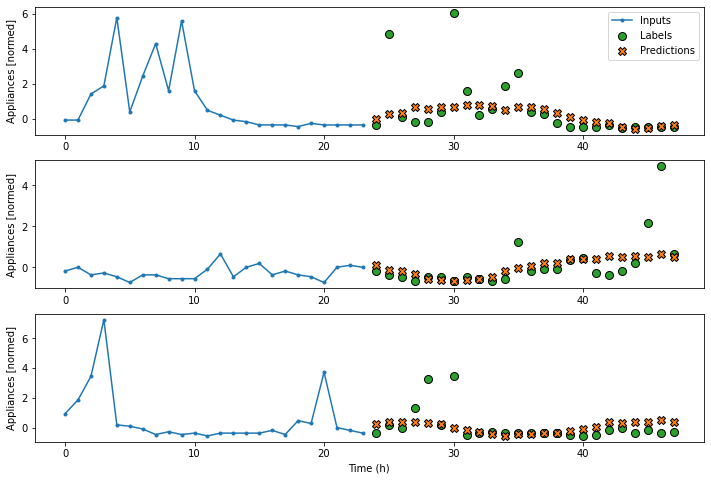

In [81]:
multi_window.plot(multi_dense_model)

CNN - Single shot

In [83]:
CONV_WIDTH = 3

multi_conv_model = Sequential([
                                 Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
                                 Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH,)),
                                 Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros),
                                 Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

multi_val_performance['CNN'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['CNN'] = multi_conv_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
71/71 [==============================] - 1s 8ms/step - loss: 0.6548 - mean_absolute_error: 0.6189 - val_loss: 0.6493 - val_mean_absolute_error: 0.5704
Epoch 2/50
71/71 [==============================] - 0s 6ms/step - loss: 0.3147 - mean_absolute_error: 0.3925 - val_loss: 0.5934 - val_mean_absolute_error: 0.5323
Epoch 3/50
71/71 [==============================] - 1s 7ms/step - loss: 0.2814 - mean_absolute_error: 0.3626 - val_loss: 0.6004 - val_mean_absolute_error: 0.5350
Epoch 4/50
71/71 [==============================] - 0s 6ms/step - loss: 0.2679 - mean_absolute_error: 0.3498 - val_loss: 0.6014 - val_mean_absolute_error: 0.5333
Epoch 5/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6183 - mean_absolute_error: 0.5412


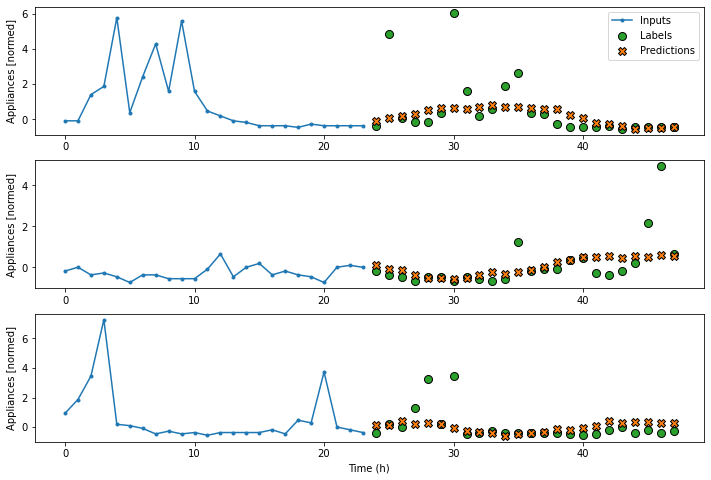

In [84]:
multi_window.plot(multi_conv_model)

LSTM - Single shot

In [85]:
multi_lstm_model = Sequential([
                                 LSTM(32, return_sequences=False),
                                 Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros),
                                 Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
71/71 [==============================] - 3s 14ms/step - loss: 0.8846 - mean_absolute_error: 0.7505 - val_loss: 1.6843 - val_mean_absolute_error: 0.9778
Epoch 2/50
71/71 [==============================] - 1s 7ms/step - loss: 0.5622 - mean_absolute_error: 0.5744 - val_loss: 1.3661 - val_mean_absolute_error: 0.8731
Epoch 3/50
71/71 [==============================] - 1s 8ms/step - loss: 0.4699 - mean_absolute_error: 0.5164 - val_loss: 1.2311 - val_mean_absolute_error: 0.8214
Epoch 4/50
71/71 [==============================] - 1s 8ms/step - loss: 0.3871 - mean_absolute_error: 0.4594 - val_loss: 1.1159 - val_mean_absolute_error: 0.7736
Epoch 5/50
71/71 [==============================] - 1s 7ms/step - loss: 0.3309 - mean_absolute_error: 0.4118 - val_loss: 1.1100 - val_mean_absolute_error: 0.7728
Epoch 6/50
71/71 [==============================] - 1s 8ms/step - loss: 0.3074 - mean_absolute_error: 0.3914 - val_loss: 1.1116 - val_mean_absolute_error: 0.7749
Epoch 7/50
71/71 [=========

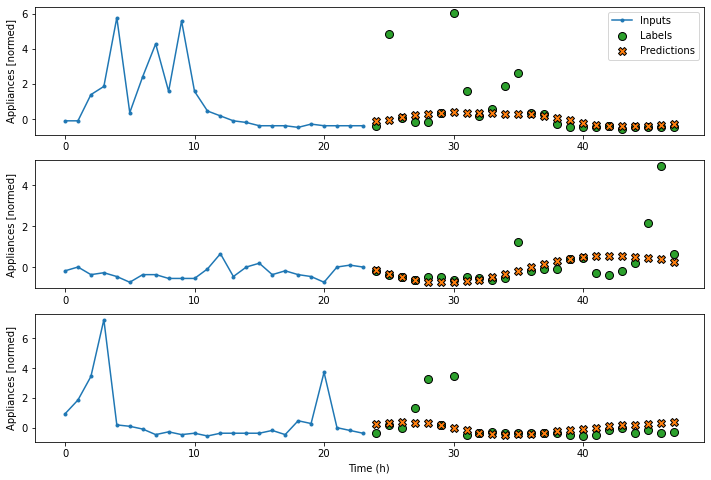

In [86]:
multi_window.plot(multi_lstm_model)

CNN + LSTM - Single shot

In [87]:
CONV_WIDTH = 3

multi_cnn_lstm_model = Sequential([
                                 Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
                                 Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH,)),
                                 LSTM(32, return_sequences=True),
                                 LSTM(32, return_sequences=False),
                                 Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros),
                                 Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_cnn_lstm_model, multi_window)

multi_val_performance['CNN+LSTM'] = multi_cnn_lstm_model.evaluate(multi_window.val)
multi_performance['CNN+LSTM'] = multi_cnn_lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
71/71 [==============================] - 4s 18ms/step - loss: 0.9391 - mean_absolute_error: 0.7778 - val_loss: 1.6271 - val_mean_absolute_error: 0.9600
Epoch 2/50
71/71 [==============================] - 1s 9ms/step - loss: 0.6000 - mean_absolute_error: 0.5934 - val_loss: 1.3147 - val_mean_absolute_error: 0.8521
Epoch 3/50
71/71 [==============================] - 1s 8ms/step - loss: 0.5259 - mean_absolute_error: 0.5459 - val_loss: 1.2129 - val_mean_absolute_error: 0.8232
Epoch 4/50
71/71 [==============================] - 1s 9ms/step - loss: 0.4879 - mean_absolute_error: 0.5236 - val_loss: 1.1790 - val_mean_absolute_error: 0.8093
Epoch 5/50
71/71 [==============================] - 1s 10ms/step - loss: 0.4291 - mean_absolute_error: 0.4861 - val_loss: 1.0695 - val_mean_absolute_error: 0.7671
Epoch 6/50
71/71 [==============================] - 1s 10ms/step - loss: 0.3875 - mean_absolute_error: 0.4558 - val_loss: 1.0252 - val_mean_absolute_error: 0.7448
Epoch 7/50
71/71 [=======

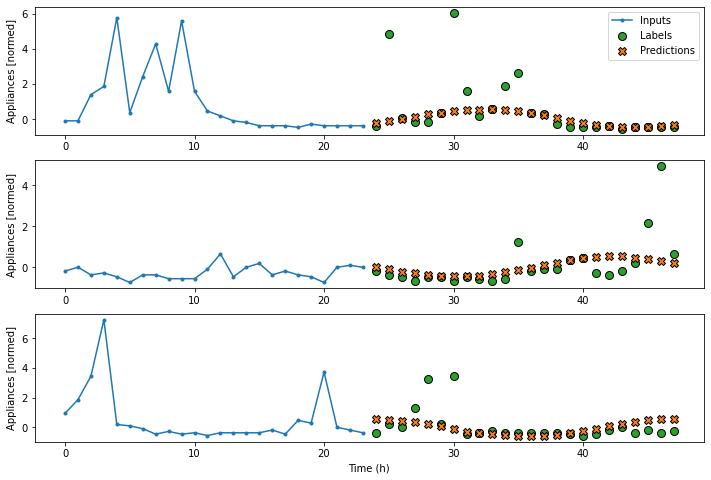

In [88]:
multi_window.plot(multi_cnn_lstm_model)

LSTM - Autoregressive

In [90]:
class FeedBack(Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = LSTMCell(units)
        self.lstm_rnn = RNN(self.lstm_cell, return_state=True)
        self.dense = Dense(num_features)

    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)

        return prediction, state

    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)

        predictions.append(prediction)

        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)

            prediction = self.dense(x)
            predictions.append(prediction)

        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])

        return predictions

In [92]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

history = compile_and_fit(feedback_model, multi_window)

multi_val_performance['LSTM-AR'] = feedback_model.evaluate(multi_window.val)
multi_performance['LSTM-AR'] = feedback_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
71/71 [==============================] - 8s 66ms/step - loss: 0.8329 - mean_absolute_error: 0.7212 - val_loss: 1.5440 - val_mean_absolute_error: 0.9254
Epoch 2/50
71/71 [==============================] - 4s 57ms/step - loss: 0.5761 - mean_absolute_error: 0.5793 - val_loss: 1.4158 - val_mean_absolute_error: 0.8815
Epoch 3/50
71/71 [==============================] - 4s 54ms/step - loss: 0.5266 - mean_absolute_error: 0.5484 - val_loss: 1.3755 - val_mean_absolute_error: 0.8669
Epoch 4/50
71/71 [==============================] - 4s 52ms/step - loss: 0.4988 - mean_absolute_error: 0.5297 - val_loss: 1.2558 - val_mean_absolute_error: 0.8270
Epoch 5/50
71/71 [==============================] - 4s 59ms/step - loss: 0.4336 - mean_absolute_error: 0.4898 - val_loss: 1.1399 - val_mean_absolute_error: 0.7848
Epoch 6/50
71/71 [==============================] - 5s 63ms/step - loss: 0.3695 - mean_absolute_error: 0.4425 - val_loss: 1.0802 - val_mean_absolute_error: 0.7623
Epoch 7/50
71/71 [====

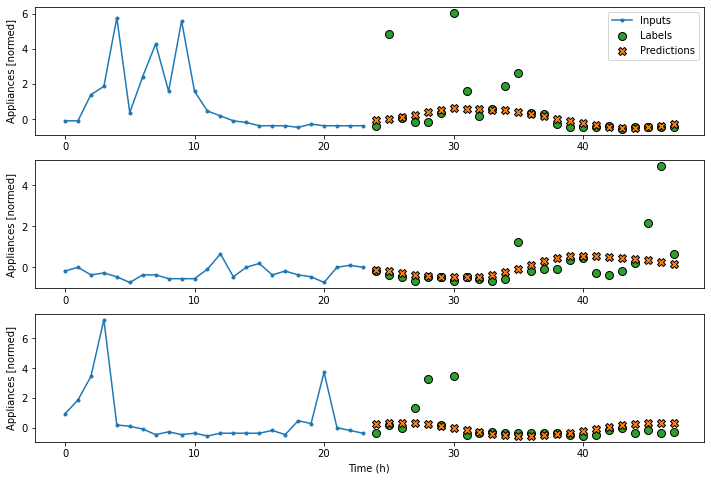

In [93]:
multi_window.plot(feedback_model)

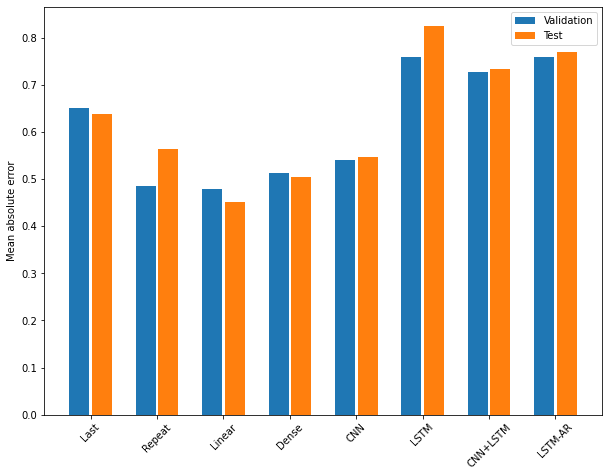

In [95]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')

val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.ylabel('Mean absolute error')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(), rotation=45)
plt.legend(loc='best')
plt.show()

In [96]:
for name, value in multi_performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

Last        : 0.6389
Repeat      : 0.5648
Linear      : 0.4507
Dense       : 0.5051
CNN         : 0.5475
LSTM        : 0.8239
CNN+LSTM    : 0.7340
LSTM-AR     : 0.7690
